In [180]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [181]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots
include("./fourier_tensor_train.jl")
includet("./bp_fourier.jl");

In [221]:
seed = 20
rng = MersenneTwister(seed)

T = 25
N = 30
c = 2.5
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)

β = 0.3
J = 1.0
h = 0.2
m⁰ = 1.0
K = 30

;

In [222]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [184]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

ising = Ising(g, fill(J,ne(g)), fill(h, nv(g)), β)
bp = Glauber(ising, T; ϕ) |> mpbp

g_ = IndexedBiDiGraph(gg)
w_fourier = [fill(GlauberFactor(fill(J,length(inedges(g,i))), h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g_, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [ ]:
matrix_sizes = [5, 10, 15]
maxiters = [0, 0, 2]
iters = zeros(Int, length(maxiters))
tol = 1e-6

for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

Iteration 1 completed


In [186]:
iters_fourier = zeros(Int, length(maxiters))
for i in eachindex(maxiters)
    iters_fourier[i], cb_fourier = iterate_fourier!(bp_fourier, K, maxiter=maxiters[i], σ=1/100; svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

In [215]:
nsamples = 10^5
sms = SoftMarginSampler(bp)
sample!(sms, nsamples);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:03


In [216]:
potts2spin(x, i; q=2) = (x-1)/(q-1)*2 - 1

i = 11
m = means(potts2spin, bp)[i]
m_fourier = real.(means(potts2spin, bp_fourier))[i]
traj = [vec(potts2spin.(X[i,:])) for X in sms.X]
m_mc = mean(traj)
;

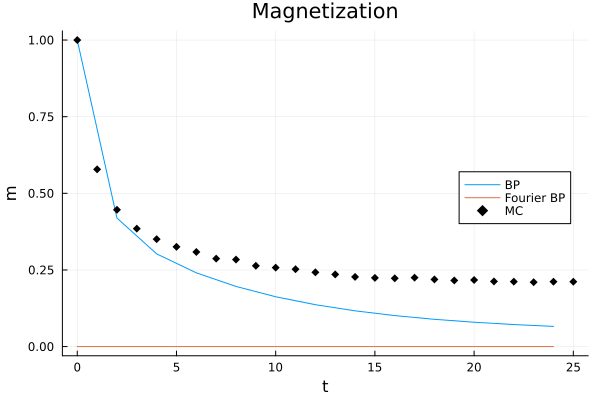

In [217]:
pl = plot(0:2:T, m[1:2:end], label="BP", xlabel="t", ylabel="m", title="Magnetization", legend=:right)
plot!(pl, 0:2:T, m_fourier[1:2:end], label="Fourier BP")
plot!(pl, 0:T, m_mc, c=:black, m=:diamond, st=:scatter, label="MC")
display(pl)

In [219]:
# using JLD2

# m = means(potts2spin, bp)
# m_fourier = real.(means(potts2spin, bp_fourier))
# traj_mc = [[vec(potts2spin.(X[i,:])) for X in sms.X] for i in 1:N]
# m_mc = [mean(x) for x in traj]
# σ_mc = [std(x)/sqrt(nsamples) for x in traj]
# jldsave("results/comparison_beta0,3_J1_h0,2_er$(N).jld2"; m, m_fourier, m_mc, σ_mc)